# 熱帶波動判識與分析

本單元主要示範如何利用Python工具判識熱帶波動訊號，而非提供熱帶波動理論完整的回顧與介紹。完整的理論介紹請參照下方所列的參考文獻。

## 熱帶波動理論簡介

熱帶波動是主導熱帶地區季內尺度變異的系統，它的理論最早在 Matsuno (1966) 文章中提出，這篇文章從熱帶 $\beta $ 面上的淺水方程 (shallow water equations) 出發，導出了熱帶波動頻散關係的理論解：  


```{math}
    \omega ^{2} - k^2 - \dfrac{k}{\omega } = 2n+1, \qquad n = 1, 2, ...  
```

若將頻散關係方程式繪圖，可以得到如下圖的結果。

:::{figure-md}
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/15874aea-bc1f-4385-b84c-26698dd2748d/rog1687-fig-0002.png">

Dispersion curves for equatorial waves (up to $n = 4$) as a function of the nondimensional frequency, $\omega ^{*}$, and nondimensional zonal wave number, $k^{*}$, where $\omega ^{*} \equiv \left( \omega /\beta \sqrt{gh_e} \right) ^{1/2}$, and $k^{*} \equiv k\left( \sqrt{gh_e} / \beta  \right) ^{1/2}$. For all but the Kelvin wave, these dispersion curves are solutions of equation (1). Westward propagating waves (relative to the zero basic state) appear on the left, and eastward propagating waves appear on the right. For consistency with equation (1), the Kelvin wave solution is labeled as $n = −1$. (Source: Kiladis et al. (2009))
:::

在這張圖中，$k^{*} > 0$ 的部分代表往東傳遞的波動，$k^{*} < 0$ 則代表往西傳遞的波動。隨後，許多觀測實驗證實了熱帶確實有這些往東和往西的波動存在，以及當衛星觀測和再分析資料越來越盛行後，從波譜分析的結果也可以發現波譜的峰值區域和理論解非常吻合，甚至可以根據波譜分析的結果進行適當的濾波來得到熱帶波動的資料。而從淺水方程式導出的波動的動力結構如下圖所示：

:::{figure-md}
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/e5386eb7-680f-46b0-9887-1f9389a70417/rog1687-fig-0003.png">

Horizontal structures of a subset of the zonally propagating wave solutions to the shallow water equations on an equatorial $\beta $ plane (equations (1)–(3)). Each is shown for a nondimensional zonal wave number, $k^{*} = \pm 1$. All scales and fields have been nondimensionalized by taking the units of time and length as given in the caption of Figure 1. The equator runs through the center of each diagram. Hatching is for divergence, and shading is for convergence, with a 0.6 unit interval between successive levels. Unshaded contours are geopotential, with a contour interval of 0.5 units. Negative contours are dashed, and the zero contour is omitted. The maximum wind vectors in each panel are specified in the bottom right corner. (Source: Kiladis et al. (2009))
:::

以下會介紹兩種常用的分析方法，其一是 Wheeler and Kiladis (1999) 提出的時空濾波法 (space-time filtering technique)，其二是 Yang et al. (2003) 提出的雙曲柱狀函數 (PCF) 投影法 (2D spatial projection on the parabolic cylinder functions, 2DS-PCF) 方法。其他還有許多熱帶波動辨識的方法，詳細的介紹與回顧請見 Knippertz et al. (2022)。 

## 時空濾波 (Space-time filtering)

時空濾波即在資料的經度和時間兩個維度軸上進行快速傅立葉變換 (fast Fourier transform, FFT)，然後將對應要保留的波段留下來，其他設為0，再進行反變換 (reversed FFT)，就可以得到濾波的資料。這個方法可以用在任何變數上，非常彈性。圖2為外逸長波輻射 (OLR) 時空頻譜的範例，可以看到幾個訊號特別強的地方，就是理論上熱帶波動的頻譜範圍。

:::{figure-md}
<img src="./images/fig.A6-1_tw_ps.png">

The wavenumber ($k$)-frequency ($\omega $) spectra of OLR data from 1981 to 2018 between 15°S and 15°N, without symmetric partition. The thick polygons indicate domains for the filtered MJO, Kelvin waves, ER waves, and MRG waves/TD-type disturbances. Source: Tsai et al. (2020).
:::

時空濾波的程式由 Carl Schreck III 團隊提供 (https://ncics.org/portfolio/monitor/mjo/)。程序簡單介紹如下：
1. 計算資料的距平，其中氣候場只保留日氣候平均的前三個球諧函數 (請見第六單元)。
2. 將資料的距平帶入時空濾波函數。

```{note}
輸入時空濾波的資料，經度範圍必須包含全球的範圍！
```

請先在程式建立以下時空濾波的函式套件 `kf_filter`。

In [1]:
#################################################
# MODULE: kf_filter
#################################################
def kf_filter(inData,obsPerDay,tMin,tMax,kMin,kMax,hMin,hMax,waveName):
    
    import numpy as np
    from scipy import signal
    import math
    
    mis = -999.
    
    timeDim = inData.shape[0]
    lonDim = inData.shape[1]
	
    # Reshape data from [time,lon] to [lon,time]
    originalData=np.zeros([lonDim,timeDim],dtype='f')
    for counterX in range(timeDim):
        test=0
        for counterY in range(lonDim-1,-1,-1):
            originalData[test,counterX]=inData[counterX,counterY]
            test+=1
	
    # Detrend the Data
    detrendData=np.zeros([lonDim,timeDim],dtype='f')
    for counterX in range(lonDim):
        detrendData[counterX,:]=signal.detrend(originalData[counterX,:])
	
    # Taper 
    taper=signal.tukey(timeDim,0.05,True)
    taperData=np.zeros([lonDim,timeDim],dtype='f')
    for counterX in range(lonDim):
        taperData[counterX,:]=detrendData[counterX,:]*taper
	
    # Perform 2-D Fourier Transform
    fftData=np.fft.rfft2(taperData)
    kDim=lonDim 
    freqDim=round(fftData.shape[1])
	
    # Find the indeces for the period cut-offs
    jMin = int(round( ( timeDim * 1. / ( tMax * obsPerDay ) ), 0 ))
    jMax = int(round( ( timeDim * 1. / ( tMin * obsPerDay ) ), 0 ))
    jMax = min( ( jMax, freqDim ) )

    # Find the indices for the wavenumber cut-offs
    # This is more complicated because east and west are separate
    if( kMin < 0 ):
        iMin = round( ( kDim + kMin ), 3 )
        iMin = max( ( iMin, ( kDim / 2 ) ) )
    else:
        iMin = round( kMin, 3 )
        iMin = min( ( iMin, ( kDim / 2 ) ) )

    if( kMax < 0 ):
        iMax = round( ( kDim + kMax ), 3 )
        iMax = max( ( iMax, ( kDim / 2 ) ) )
    else:
        iMax = round( kMax, 3 )
        iMax = min( ( iMax, ( kDim / 2 ) ) )
	  
    # set the appropriate coefficients to zero
    iMin=int(iMin)
    iMax=int(iMax)
    jMin=int(jMin)
    jMax=int(jMax)
    if( jMin > 0 ):
        fftData[:, :jMin-1 ] = 0
    if( jMax < ( freqDim - 1 ) ):
        fftData[:, jMax+1: ] = 0

    if( iMin < iMax ):
        # Set things outside the range to zero, this is more normal
        if( iMin > 0 ):
            fftData[:iMin-1, : ] = 0
        if( iMax < ( kDim - 1 ) ):
            fftData[iMax+1:, : ] = 0
    else:
        # Set things inside the range to zero, this should be somewhat unusual
        fftData[iMax+1:iMin-1, : ] = 0
	
    # Find constants
    PI = math.pi
    beta = 2.28e-11
    if hMin != -999:
        cMin = float( 9.8 * float(hMin) )**0.5
    else:
        cMin=hMin
    if hMax != -999:
        cMax = float( 9.8 * float(hMax) )**0.5
    else:
        cMax=hMax
    c = np.array([cMin,cMax])
    spc = 24 * 3600. / ( 2 * PI * obsPerDay ) # seconds per cycle
	
    # Now set things to zero that are outside the Kelvin dispersion
    for i in range(0,kDim):
        # Find Non-Dimensional WaveNumber (k)
        if( i > ( kDim / 2 ) ):
            # k is negative
            k = ( i - kDim  ) * 1. / (6.37e6) # adjusting for circumfrence of earth
        else:
            # k is positive
            k = i * 1. / (6.37e6) # adjusting for circumfrence of earth

        # Find Frequency
        freq = np.array([ 0, freqDim * (1. / spc) ]) #waveName='None'
        jMinWave = 0
        jMaxWave = freqDim	
        if waveName.lower() == "kelvin":
            freq = k * c
        if waveName.lower() == "er":
            freq = -beta * k / ( k**2 + 3. * beta / c )
        if waveName.lower() == "ig1":
            freq = ( 3 * beta * c + k**2 * c**2 )**0.5
        if waveName.lower() == "ig2":
            freq = ( 5 * beta * c + k**2 * c**2 )**0.5
        if waveName.lower() == "mrg" or waveName.lower()=="ig0":   	
           if( k == 0 ):
               freq = ( beta * c )**0.5
           else:
               if( k > 0):
                   freq = k * c * ( 0.5 + 0.5 * ( 1 + 4 * beta / ( k**2 * c ) )**0.5 )
               else:
                freq = k * c * ( 0.5 - 0.5 * ( 1 + 4 * beta / ( k**2 * c ) )**0.5 )	
		
        # Get Min/Max Wave 
        if(hMin==mis):
            jMinWave = 0
        else:
            jMinWave = int( math.floor( freq[0] * spc * timeDim ) )

        if(hMax==mis):
            jMaxWave = freqDim
        else:
            jMaxWave = int( math.ceil( freq[1] * spc * timeDim ) )

        jMaxWave = max(jMaxWave, 0)
        jMinWave = min(jMinWave, freqDim)
		
        # set the appropriate coefficients to zero
        i=int(i)
        jMinWave=int(jMinWave)
        jMaxWave=int(jMaxWave)
        if( jMinWave > 0 ):
            fftData[i, :jMinWave-1] = 0
        if( jMaxWave < ( freqDim - 1 ) ):
            fftData[i, jMaxWave+1:] = 0
	
    # perform the inverse transform to reconstruct the data
    returnedData=np.fft.irfft2(fftData) 
	
    # Reshape data from [lon,time] to [time,lon]
    outData=np.zeros([timeDim,lonDim],dtype='f')
    for counterX in range(returnedData.shape[1]):
        test=0
        for counterY in range(lonDim-1,-1,-1):
            outData[counterX,counterY]=returnedData[test,counterX] 
            test+=1
    
    # Return Result
    return (outData)


以及計算氣候場前三個球諧函數 (這部分和第六單元是完全一樣的)。

In [2]:
def smthClmDay(clmDay, nHarm):
    
    from scipy.fft import rfft, irfft
    
    nt, ny, nx = clmDay.shape
    cf = rfft(clmDay.values, axis=0)     # xarray.DataArray.values 可將DataArray 轉換成numpy.ndarray。
    cf[nHarm,:,:] = 0.5*cf[nHarm,:,:]    # mini-taper.
    cf[nHarm+1:,:,:] = 0.0               # set all higher coef to 0.0
    icf = irfft(cf, n=nt, axis=0)       # reconstructed series
    clmDaySmth = clmDay.copy(data=icf, deep=False)
    return(clmDaySmth)

接著我們讀取OLR資料，計算其距平。

In [3]:
# Import modules
import numpy as np
import xarray as xr

lats, latn = -20, 20 # 只選擇熱帶範圍
name = 'olra'

olr = xr.open_dataset('./data/olr.nc').sel(lat=slice(lats,latn)).olr
olrDayClm = olr.groupby('time.dayofyear').mean('time')
olrDayClm_sm = smthClmDay(olrDayClm, 3)
# 只選2017, 2018年做範例，可以選任意時間長度 (建議至少1年)
olra = olr.sel(time=slice('2017-01-01','2018-12-31')).groupby('time.dayofyear') - olrDayClm_sm 

olra

<xarray.DataArray 'olr' (time: 730, lat: 40, lon: 360)> Size: 42MB
array([[[ 16.380737  ,  17.168976  ,  17.851715  , ...,  17.053497  ,
          16.067688  ,  15.664856  ],
        [ 16.75711   ,  17.412567  ,  17.013672  , ...,  12.450287  ,
          13.341797  ,  15.062714  ],
        [ 14.054718  ,  14.679474  ,  14.075836  , ...,   9.722412  ,
          11.569977  ,  12.888275  ],
        ...,
        [ 11.100403  ,  10.695862  ,  10.360992  , ...,  11.227478  ,
          12.538239  ,  10.187195  ],
        [  8.687775  ,   9.050079  ,   7.7844543 , ...,  11.915253  ,
          11.584717  ,  10.397156  ],
        [ 11.788086  ,   8.504059  ,   6.5397644 , ...,  16.114624  ,
          14.831299  ,  11.902313  ]],

       [[ 16.882385  ,  16.851288  ,  17.246857  , ...,  18.198883  ,
          16.867859  ,  16.242859  ],
        [ 15.078796  ,  13.773102  ,  13.533112  , ...,  20.839447  ,
          17.823395  ,  15.5312195 ],
        [ 11.530273  ,  12.067505  ,  15.291046  , ...,  14.027985  ,
          11.882843  ,  10.712891  ],
...
        [-34.450195  , -43.519882  , -34.36876   , ..., -13.596405  ,
         -18.143631  , -31.10968   ],
        [-18.831161  , -26.859772  , -31.448883  , ...,  10.565292  ,
          -2.8655548 , -10.68837   ],
        [  6.0747986 ,  -3.823471  , -15.938919  , ...,  18.611649  ,
          17.26979   ,  11.514557  ]],

       [[ -9.893219  ,  -7.201172  ,  -0.78356934, ...,  -1.2973328 ,
          -3.3666992 ,  -6.482971  ],
        [-19.12323   , -15.406616  ,  -9.28949   , ...,  -7.4835205 ,
          -9.953247  , -10.572845  ],
        [-23.6315    , -27.043625  , -16.556519  , ..., -11.582275  ,
         -13.263733  , -13.371033  ],
        ...,
        [ -7.89328   ,  -5.9326477 ,  -5.8309326 , ..., -25.945755  ,
         -13.093399  , -12.713745  ],
        [-10.086914  ,  -4.398468  ,  -7.0507355 , ..., -11.004013  ,
         -10.912903  ,  -6.5914    ],
        [ -3.9571838 ,  -2.9132996 ,   3.1249695 , ..., -12.475006  ,
          -5.3866425 ,  -1.2779846 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2017-01-01 2017-01-02 ... 2018-12-31
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float32 160B -19.5 -18.5 -17.5 -16.5 ... 17.5 18.5 19.5
    dayofyear  (time) int64 6kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

接著，建立各個波段的空DataArray，然後設定各個波段的波數、週期、equivalent depth參數。其中，equivalent depth只適用有頻散關係理論解的波動 (Kelvin, ER, MRG)，其他波動的請設定為`mis`。

In [4]:
# wave filter
mis = -999.
obsPerDay = 1.
lat = olra.lat.values

lf     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mjo    = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
er     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
kelvin = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mt     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mrg    = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))

# lf parameters 
lf_filter="above 120 days"
lf_wavenumber=np.array([mis,mis],dtype='f')
lf_period=np.array([120,mis],dtype='f')
lf_depth=np.array([mis*-1.,mis],dtype='f')

# mjo parameters 
mjo_filter="Kiladis et al. (2005 JAS) for 20-100"
mjo_wavenumber=np.array([1,5],dtype='f')
mjo_period=np.array([30,96],dtype='f')
mjo_depth=np.array([mis,mis],dtype='f')
    
# er parameters 
er_filter="Kiladis et al. (2009 Rev. Geophys.)"
er_wavenumber=np.array([-10,-1],dtype='f')
er_period=np.array([9.7,48],dtype='f')
er_depth=np.array([8,90],dtype='f')

# kw parameters
kelvin_filter="Straub & Kiladis (2002) to 20 days"
kelvin_wavenumber=np.array([1,14],dtype='f')
kelvin_period=np.array([2.5,30],dtype='f')
kelvin_depth=np.array([8,90],dtype='f')

# mt parameters
mt_filter="MRG-TD type wave filter (Frank & Roundy 2006)"
mt_wavenumber=np.array([-14,0],dtype='f')
mt_period=np.array([2.5,10],dtype='f')
mt_depth=np.array([mis,mis],dtype='f')

# mrg parameters
mrg_filter="MRG-TD type wave filter"
mrg_wavenumber=np.array([-10,-1],dtype='f')
mrg_period=np.array([3,9.6],dtype='f')
mrg_depth=np.array([8,90],dtype='f')

接著一個緯度一個緯度進行2D-FFT的濾波。  

其中，`kf_filter (inData,obsPerDay,tMin,tMax,kMin,kMax,hMin,hMax,waveName)`。  

- `inData`代表輸入的資料，
- `obsPerDay` 代表一天有幾筆觀測資料 (即資料的取樣頻率)，
- `tMin`、`tMax`代表濾波頻段週期的最小最大值，
- `kMin`、`kMax`代表波數範圍最小最大值，
- `hMin`、`hMax`代表equivalent depth的最小最大值，
- `waveName`是波動的名稱，如果Kelvin, ER, MRG以外的系統，由於程式中沒有設定好的頻散關係，請直接寫`none`即可。

In [5]:
for y in lat: 
    #print('latitude: ' + str(y))
    #################################################
    # Filter
    #################################################
    #lf
    lf.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                        obsPerDay,
                        lf_period[0],lf_period[1],
                        lf_wavenumber[0],lf_wavenumber[1],
                        lf_depth[0],lf_depth[1],"none")
    
    #mjo
    mjo.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                        obsPerDay,
                        mjo_period[0],mjo_period[1],
                        mjo_wavenumber[0],mjo_wavenumber[1],
                        mjo_depth[0],mjo_depth[1],"none")
    
    #er 
    er.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                       obsPerDay,
                       er_period[0],er_period[1],
                       er_wavenumber[0],er_wavenumber[1],
                       er_depth[0],er_depth[1],"er")
    
    ## kw
    kelvin.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                           obsPerDay,
                           kelvin_period[0],kelvin_period[1],
                           kelvin_wavenumber[0],kelvin_wavenumber[1],
                           kelvin_depth[0],kelvin_depth[1],"kelvin")
    
    # mt 
    mt.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                       obsPerDay,
                       mt_period[0],mt_period[1],
                       mt_wavenumber[0],mt_wavenumber[1],
                       mt_depth[0],mt_depth[1],"none")
        
    # mrg 
    mrg.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                        obsPerDay,
                        mrg_period[0],mrg_period[1],
                        mrg_wavenumber[0],mrg_wavenumber[1],
                        mrg_depth[0],mrg_depth[1],"mrg")
    
er

AttributeError: module 'scipy.signal' has no attribute 'tukey'

最後可以輸出資料：

In [6]:
# Output files

outdir = './data/olr_ccew_sample/'

#print(lf) 
lf.to_netcdf(outdir+'olr_2017-2018_LF.nc',unlimited_dims='time')

#print(mjo)
mjo.to_netcdf(outdir+'olr_2017-2018_MJO.nc',unlimited_dims='time')

#print(er)
er.to_netcdf(outdir+'olr_2017-2018_ER.nc',unlimited_dims='time')

#print(kelvin)
kelvin.to_netcdf(outdir+'olr_2017-2018_KW.nc',unlimited_dims='time')

#print(mt)
mt.to_netcdf(outdir+'olr_2017-2018_MT.nc',unlimited_dims='time')

#print(mrg)
mrg.to_netcdf(outdir+'olr_2017-2018_MRG.nc',unlimited_dims='time')

我們選定2017/12-2018/02期間，繪製5˚-15˚N平均的 OLR、濾波的MJO、ER波、MRG/TD波哈莫圖。

In [7]:
import cmaps
cmap=cmaps.sunshine_diff_12lev

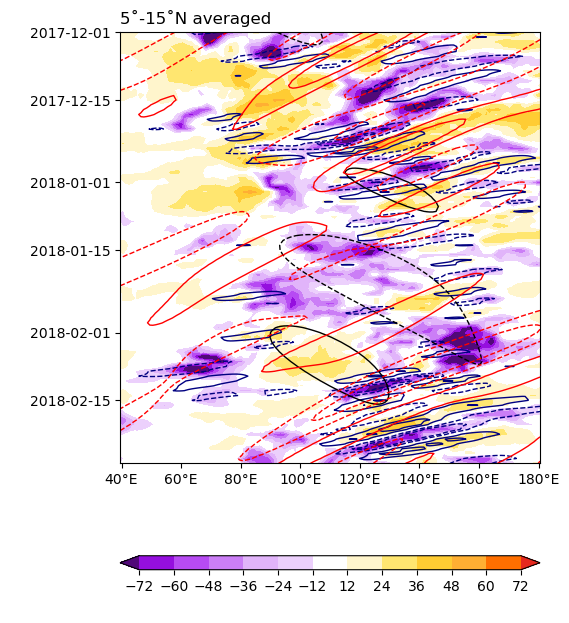

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmaps

time1 = '2017-12-01'
time2 = '2018-02-28'
lon1 = 39 
lon2 = 181
lats = 5
latn = 15

olrh     =   olra.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
er_hovm  =     er.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
mjo_hovm =    mjo.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
mt_hovm  =     mt.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
kw_hovm  = kelvin.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)

# Plot settings
plt.figure(figsize=(6, 8))     
ax = plt.axes() 
ax.set_xticks(np.arange(40,200,20))
lon_formatter = LONGITUDE_FORMATTER
ax.xaxis.set_major_formatter(lon_formatter)

clevs = [-72,-60,-48,-36,-24,-12,12,24,36,48,60,72]
plt.title("OLR anomaly", loc='left')
hovm_plot = olrh.plot.contourf(x="lon", y="time",
                               ax=ax, 
                               levels=clevs,                    
                               cmap=cmap,  
                               yincrease=False,                 # y axis be increasing from top to bottom
                               add_colorbar=True, 
                               extend='both',                   # color bar 兩端向外延伸
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' ', 'ticks':clevs})
#kw_plot = kw_hovm.plot.contour(x='lon',y='time', ax=ax,
#                               levels=[-30,-15,15,30], 
#                               colors='blue',linewidths=1,
#                               yincrease=False) 
mt_plot = mt_hovm.plot.contour(x='lon',y='time', ax=ax,
                               levels=[-30,-15,15,30], 
                               colors='navy',linewidths=1,
                               yincrease=False) 
mjo_plot = mjo_hovm.plot.contour(x='lon',y='time', ax=ax,
                                 levels=[-30,-20,-10,10,20,30], 
                                 colors='black',linewidths=1,
                                 yincrease=False)
er_plot  = er_hovm.plot.contour(x='lon',y='time', ax=ax,
                                levels=[-30,-20,-10,10,20,30], 
                                colors='red',linewidths=1,
                                yincrease=False)

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title(' ')
ax.set_title('5˚-15˚N averaged', loc='left')

plt.subplots_adjust(left=0.2)

plt.show()

上圖中，底色是濾波前OLR距平，黑色往東的等值線代表MJO，紅色往西的等值線代表赤道羅士比波 (ER waves)，深藍色往西的等值線是混合羅士比－重力波和熱帶擾動 (MRG/TD wave)，且實線 (正值) 代表對流抑制相位，虛線 (負值) 代表對流活躍相位。

## 雙曲柱狀函數投影法 (2DS-PCF)

在Yang et al. (2003) 中，他們指出由於熱帶波動會受到背景場調節，產生都卜勒效應，波動的頻散關係會被改變，因此像Wheeler and Kiladis (1999) 的方法去限制一個窄的時空頻段來進行濾波，可能會造成有部分的波動訊號被忽略。因此，他們只對動力場 (u, v, z) 做一個寬帶濾波，波數的範圍是 $1\leq \left| k\right| \leq 15$，週期的範圍是 $2\leq \left| T\right| \leq 30$ 天， 再將寬帶濾波後的動力場分別投影至各個波動模態的理論解上，此時得到的就是熱帶波動，其中理論解釋是根據 Gill (1980) ，這篇文章假定表面有加熱的作用，加入淺水方程中，導出的解就是雙曲柱狀函數的形式。

:::{figure-md}
<img src="https://rmets.onlinelibrary.wiley.com/cms/asset/0cf13e1c-5d09-4004-9f66-8dc3b634d610/qj4338-fig-0002-m.jpg">

Latitudinal profiles of different equatorial wave solutions. Spherical solutions for (a) Kelvin wave zonal wind $u^{\prime }$ and (b) mixed Rossby–gravity wave (MRG) meridional wind $v^{\prime }$, both for $D$ = 8 m and 90 m and for $k$ = 1 and $k$ = 20, as well as (c) the $n$ = 1 equatorial Rossby wave (ER) $u^{\prime }, v^{\prime }$, and geopotential $\phi ^{\prime }$ for $k$ = 1 and $D$ = 90 m. These curves were produced using the software developed by Swarztrauber and Kasahara (1985). (d) Parabolic cylinder functions (PCFs) 0, 1, and 2 for $y_0 = 6$. The 15° S–15° N belt used for averaging throughout the paper is shaded in grey. Source: Knippertz et al. 2023. 
:::

```{note}
1. 這個方法必須同時使用u, v, z三個變數！
2. 這個方法不能濾MJO的訊號！
```

2DS-PCF方法的程式，是由Professor Steven Woolnough 和 Dr. Gui-Ying Yang (University of Reading) 提供，並在 Dr. Sandro Lubis的GitHub網頁下載 (https://github.com/sandrolubis/CCEWs-PCF-Filter)。以下示範對2016-2020年的u, v, z資料進行熱帶波動辨識 (此處示範使用Dr. Lubis提供的範例資料檔)。 

In [9]:
'''
; Authors: Prof. Steven Woolnough and Dr. Gui-Ying Yang
;          Modified by Dr. Sandro W. Lubis (Nov 2021)
;          CCEW Filter via PCFs following Yang et al., (2003)
; Contact: slubis.geomar@gmail.com
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
'''
import numpy as np
import pandas as pd
import xarray as xr
import pandas as pd
from scipy import signal
from metpy.units import units

### Read data and calculate anomaly

lev = 850

# Open files 
ua = xr.open_dataarray('./data/u.850.20N-20S.0-360.20160101-20201231.nc')
va = xr.open_dataarray('./data/v.850.20N-20S.0-360.20160101-20201231.nc')
za = xr.open_dataarray('./data/phi.850.20N-20S.0-360.20160101-20201231.nc')

### 2DS-PCF starts (以下都不需要更動)
u = signal.detrend(ua.values, axis=0)
v = signal.detrend(va.values, axis=0)
z = signal.detrend(za.values, axis=0)

wgt_taper = signal.tukey(u.shape[0], alpha=0.1)

uT = np.transpose(u, (1, 2, 0)) * np.reshape(wgt_taper, (-1, u.shape[0]))
vT = np.transpose(v, (1, 2, 0)) * np.reshape(wgt_taper, (-1, v.shape[0]))
zT = np.transpose(z, (1, 2, 0)) * np.reshape(wgt_taper, (-1, z.shape[0]))

u = np.transpose(uT, (2, 0, 1))
v = np.transpose(vT, (2, 0, 1))
z = np.transpose(zT, (2, 0, 1))

g     = 9.8
beta  = 2.3e-11
radea = 6.371e+06
spd   = 86400.0
ww    = 2.0 * np.pi / spd

latmax = 20.0

kmin = 2
kmax = 20

pmin = 3.0
pmax = 30.0

# convert trapping scale to meters
y0 = 6.0
y0real = 2.0 * np.pi * radea * y0 / 360.0

ce = 2.0 * y0real**2 * beta

g_on_c = g / ce
c_on_g = ce / g

waves = np.array(['Kelvin', 'WMRG', 'R1', 'R2'])

# transform u,z to q, r using q=z*(g/c) + u; r=z*(g/c) - u 

q = z * g_on_c + u
r = z * g_on_c - u

qf = np.fft.fft2(q, axes=(0, 2))
vf = np.fft.fft2(v, axes=(0, 2))
rf = np.fft.fft2(r, axes=(0, 2))

nf = qf.shape[0]
nlat = qf.shape[1]
nk = qf.shape[2]

# Find frequencies and wavenumbers corresponding to pmin,pmax and kmin,kmax in coeff matrices

f = np.fft.fftfreq(nf)
k = np.fft.fftfreq(nk) * nk

fmin = np.where(f >= 1.0 / pmax)[0][0]
fmax = (np.where(f > 1.0 / pmin)[0][0]) - 1

f1p = fmin
f2p = fmax + 1
f1n = nf - fmax
f2n = nf - fmin + 1

k1p = kmin
k2p = kmax + 1
k1n = nk - kmax
k2n = nk - kmin + 1

# Define the parobolic cylinder functions

spi2 = np.sqrt(2.0 * np.pi)
dsq = np.array([spi2, spi2, 2.0 * spi2, 6.0 * spi2])
d = np.zeros((dsq.size, nlat))
y = ua.Y.values / y0
ysq = y**2

d[0, :] = np.exp(-ysq / 4.0)
d[1, :] = y * d[0, :]
d[2, :] = (ysq - 1.0) * d[0, :]
d[3, :] = y * (ysq - 3.0) * d[0, :]

dlat = np.abs(ua.Y.values[1] - ua.Y.values[0]) * np.pi / 180.0

qf_Kel = np.zeros((nf, nk), dtype='complex')

qf_mode = np.zeros((dsq.size, nf, nk), dtype='complex')
vf_mode = np.zeros((dsq.size, nf, nk), dtype='complex')
rf_mode = np.zeros((dsq.size, nf, nk), dtype='complex')

# reorder the spectral coefficents to make the latitudes the last dimension

qf = np.transpose(qf, (0, 2, 1))
vf = np.transpose(vf, (0, 2, 1))
rf = np.transpose(rf, (0, 2, 1))

for m in np.arange(dsq.size):
    if m == 0:
        qf_Kel[f1n:f2n, k1p:k2p] = np.sum(qf[f1n:f2n, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
        qf_Kel[f1p:f2p, k1n:k2n] = np.sum(qf[f1p:f2p, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    
    qf_mode[m, f1n:f2n, k1n:k2n] = np.sum(qf[f1n:f2n, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    qf_mode[m, f1p:f2p, k1p:k2p] = np.sum(qf[f1p:f2p, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    
    vf_mode[m, f1n:f2n, k1n:k2n] = np.sum(vf[f1n:f2n, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    vf_mode[m, f1p:f2p, k1p:k2p] = np.sum(vf[f1p:f2p, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    
    rf_mode[m, f1n:f2n, k1n:k2n] = np.sum(rf[f1n:f2n, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    rf_mode[m, f1p:f2p, k1p:k2p] = np.sum(rf[f1p:f2p, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)

uf_wave = np.zeros((waves.size, nf, nlat, nk), dtype='complex')
vf_wave = np.zeros((waves.size, nf, nlat, nk), dtype='complex')
zf_wave = np.zeros((waves.size, nf, nlat, nk), dtype='complex')

for w in np.arange(waves.size):
    if waves[w] == 'Kelvin':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * qf_Kel * d[0, j]
            zf_wave[w, :, j, :] = 0.5 * qf_Kel * d[0, j] * c_on_g
    
    if waves[w] == 'WMRG':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * qf_mode[1, :, :] * d[1, j]
            vf_wave[w, :, j, :] = 0.5 * vf_mode[0, :, :] * d[0, j]
            zf_wave[w, :, j, :] = 0.5 * qf_mode[1, :, :] * d[1, j] * c_on_g
    
    if waves[w] == 'R1':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * (qf_mode[2, :, :] * d[2, j] - rf_mode[0, :, :] * d[0, j])
            vf_wave[w, :, j, :] = 0.5 * vf_mode[1, :, :] * d[1, j]
            zf_wave[w, :, j, :] = 0.5 * (qf_mode[2, :, :] * d[2, j] + rf_mode[0, :, :] * d[0, j]) * c_on_g
    
    if waves[w] == 'R2':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * (qf_mode[3, :, :] * d[3, j] - rf_mode[1, :, :] * d[1, j])
            vf_wave[w, :, j, :] = 0.5 * vf_mode[2, :, :] * d[2, j]
            zf_wave[w, :, j, :] = 0.5 * (qf_mode[3, :, :] * d[3, j] + rf_mode[1, :, :] * d[1, j]) * c_on_g

u_Kelvin = xr.DataArray(np.real(np.fft.ifft2(uf_wave[0, :, :, :], axes=(0, 2))), coords=[ua['T'], ua['Y'], ua['X']], dims=['T', 'Y', 'X'], name='u')
v_Kelvin = xr.DataArray(np.real(np.fft.ifft2(vf_wave[0, :, :, :], axes=(0, 2))), coords=[va['T'], va['Y'], va['X']], dims=['T', 'Y', 'X'], name='v')
z_Kelvin = xr.DataArray(np.real(np.fft.ifft2(zf_wave[0, :, :, :], axes=(0, 2))), coords=[za['T'], za['Y'], za['X']], dims=['T', 'Y', 'X'], name='z')

u_Kelvin.attrs['long_name'] = 'Kelvin Waves in '+ str(lev) + ' hPa Zonal Wind'
v_Kelvin.attrs['long_name'] = 'Kelvin Waves in '+ str(lev) + ' hPa Meridional Wind'
z_Kelvin.attrs['long_name'] = 'Kelvin Waves in '+ str(lev) + ' hPa Geopotential Height'

u_Kelvin.attrs['units'] = 'm/s'
v_Kelvin.attrs['units'] = 'm/s'
z_Kelvin.attrs['units'] = 'm'

u_WMRG = xr.DataArray(np.real(np.fft.ifft2(uf_wave[1, :, :, :], axes=(0, 2))), coords=[ua['T'], ua['Y'], ua['X']], dims=['T', 'Y', 'X'], name='u')
v_WMRG = xr.DataArray(np.real(np.fft.ifft2(vf_wave[1, :, :, :], axes=(0, 2))), coords=[va['T'], va['Y'], va['X']], dims=['T', 'Y', 'X'], name='v')
z_WMRG = xr.DataArray(np.real(np.fft.ifft2(zf_wave[1, :, :, :], axes=(0, 2))), coords=[za['T'], za['Y'], za['X']], dims=['T', 'Y', 'X'], name='z')

u_WMRG.attrs['long_name'] = 'Westward Mixed Rossby-Gravity Waves in '+ str(lev) + ' hPa Zonal Wind'
v_WMRG.attrs['long_name'] = 'Westward Mixed Rossby-Gravity Waves in '+ str(lev) + ' hPa Meridional Wind'
z_WMRG.attrs['long_name'] = 'Westward Mixed Rossby-Gravity Waves in '+ str(lev) + ' hPa Geopotential Height'

u_WMRG.attrs['units'] = 'm/s'
v_WMRG.attrs['units'] = 'm/s'
z_WMRG.attrs['units'] = 'm'

u_R1 = xr.DataArray(np.real(np.fft.ifft2(uf_wave[2, :, :, :], axes=(0, 2))), coords=[ua['T'], ua['Y'], ua['X']], dims=['T', 'Y', 'X'], name='u')
v_R1 = xr.DataArray(np.real(np.fft.ifft2(vf_wave[2, :, :, :], axes=(0, 2))), coords=[va['T'], va['Y'], va['X']], dims=['T', 'Y', 'X'], name='v')
z_R1 = xr.DataArray(np.real(np.fft.ifft2(zf_wave[2, :, :, :], axes=(0, 2))), coords=[za['T'], za['Y'], za['X']], dims=['T', 'Y', 'X'], name='z')

u_R1.attrs['long_name'] = 'n = 1 Equatorial Rossby Waves in '+ str(lev) + ' hPa Zonal Wind'
v_R1.attrs['long_name'] = 'n = 1 Equatorial Rossby Waves in '+ str(lev) + ' hPa Meridional Wind'
z_R1.attrs['long_name'] = 'n = 1 Equatorial Rossby Waves in '+ str(lev) + ' hPa Geopotential Height'

u_R1.attrs['units'] = 'm/s'
v_R1.attrs['units'] = 'm/s'
z_R1.attrs['units'] = 'm'

u_R2 = xr.DataArray(np.real(np.fft.ifft2(uf_wave[3, :, :, :], axes=(0, 2))), coords=[ua['T'], ua['Y'], ua['X']], dims=['T', 'Y', 'X'], name='u')
v_R2 = xr.DataArray(np.real(np.fft.ifft2(vf_wave[3, :, :, :], axes=(0, 2))), coords=[va['T'], va['Y'], va['X']], dims=['T', 'Y', 'X'], name='v')
z_R2 = xr.DataArray(np.real(np.fft.ifft2(zf_wave[3, :, :, :], axes=(0, 2))), coords=[za['T'], za['Y'], za['X']], dims=['T', 'Y', 'X'], name='z')

u_R2.attrs['long_name'] = 'n = 2 Equatorial Rossby Waves in '+ str(lev) + ' hPa Zonal Wind'
v_R2.attrs['long_name'] = 'n = 2 Equatorial Rossby Waves in '+ str(lev) + ' hPa Meridional Wind'
z_R2.attrs['long_name'] = 'n = 2 Equatorial Rossby Waves in '+ str(lev) + ' hPa Geopotential Height'

u_R2.attrs['units'] = 'm/s'
v_R2.attrs['units'] = 'm/s'
z_R2.attrs['units'] = 'm' 

到此熱帶波動投影的程序已經結束。以下也可以輸出資料：

In [10]:
u_Kelvin.to_netcdf('./data/yhs03_ccews/u.850.kelvin.2016-2020.nc',unlimited_dims='T')
v_Kelvin.to_netcdf('./data/yhs03_ccews/v.850.kelvin.2016-2020.nc',unlimited_dims='T')
z_Kelvin.to_netcdf('./data/yhs03_ccews/z.850.kelvin.2016-2020.nc',unlimited_dims='T')

u_WMRG.to_netcdf('./data/yhs03_ccews/u.850.wmrg.2016-2020.nc',unlimited_dims='T')
v_WMRG.to_netcdf('./data/yhs03_ccews/v.850.wmrg.2016-2020.nc',unlimited_dims='T')
z_WMRG.to_netcdf('./data/yhs03_ccews/z.850.wmrg.2016-2020.nc',unlimited_dims='T')

u_R1.to_netcdf('./data/yhs03_ccews/u.850.r1.2016-2020.nc',unlimited_dims='T')
v_R1.to_netcdf('./data/yhs03_ccews/v.850.r1.2016-2020.nc',unlimited_dims='T')
z_R1.to_netcdf('./data/yhs03_ccews/z.850.r1.2016-2020.nc',unlimited_dims='T')

u_R2.to_netcdf('./data/yhs03_ccews/u.850.r2.2016-2020.nc',unlimited_dims='T')
v_R2.to_netcdf('./data/yhs03_ccews/v.850.r2.2016-2020.nc',unlimited_dims='T')
z_R2.to_netcdf('./data/yhs03_ccews/z.850.r2.2016-2020.nc',unlimited_dims='T')


我們繪製2019年12月16日這4種波動的平面圖。

Text(0.5, 0.95, 'GPH (Shade.), 850-hPa Wind Anml. (vectors)')

Error in callback <function _draw_all_if_interactive at 0x189a96680> (for post_execute):


ValueError: For units of inches or points a fig kwarg is needed

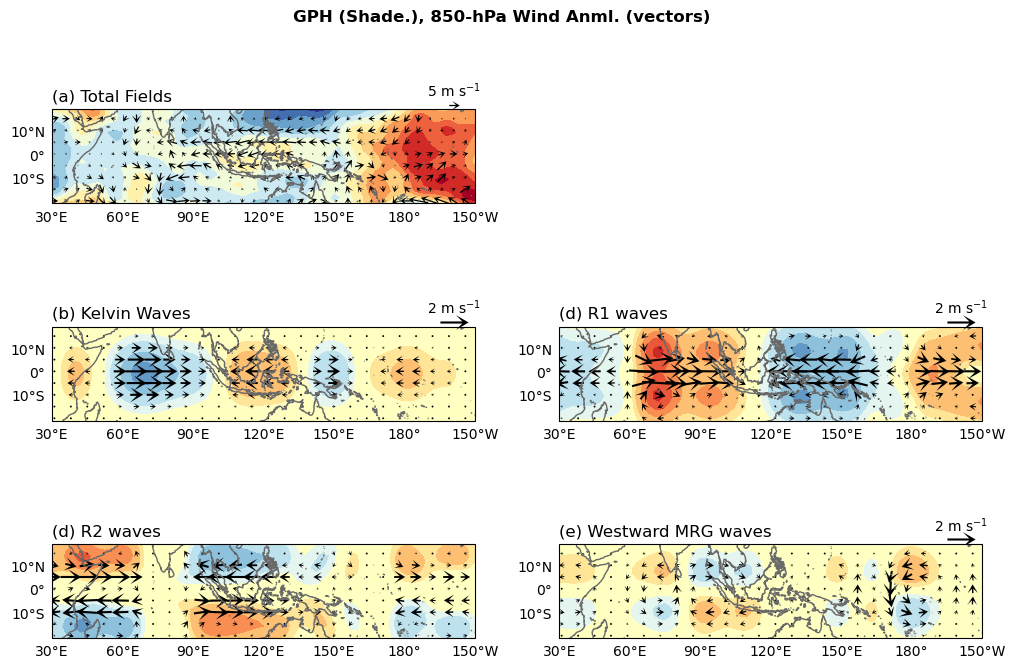

In [11]:
import xarray as xr 
import numpy as np 
import cmaps
from matplotlib import pyplot as plt
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER

time = '2019-12-15 12:00:00'
lon1, lon2 =  30, 210
lats, latn = -20,  20
lb = ['a','b','d','c','e']

# Define the figure and each axis for the 3 rows and 3 columns
proj = ccrs.PlateCarree(central_longitude=180) 
fig, axes = plt.subplots(nrows=3,ncols=2,
                         subplot_kw={'projection': proj}, 
                         figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
ax = axes.flatten()

#### Plot Total fields 
cf1 = (za.sel(T=time,X=slice(lon1,lon2))
         .plot.contourf(x="X", y="Y", 
                        levels=[-25,-20,-15,-10,-5,0,5,10,15,20,25],
                        cmap='RdYlBu',
                        add_colorbar=False, extend='both',
                        transform=ccrs.PlateCarree(),
                        ax=ax[0]))
tot_wnd = (xr.merge([ua,va]).sel(T=time,X=slice(lon1,lon2))
                            .interp(X=np.arange(31,211,5),Y=np.arange(-19,24,5)))
qv = (tot_wnd.plot.quiver(ax=ax[0],
                          transform=ccrs.PlateCarree(),
                          x='X', y='Y',
                          u='u', v='v',
                          width=0.003 ,headaxislength=3,headlength=6,headwidth=7,
                          scale=200, colors="black",add_guide=False
                          ))
ax[0].set_title('')
ax[0].set_title("(a) Total Fields",loc='left')
qk = 5
qv_key = ax[0].quiverkey(qv,0.95,1.05,qk,(str(qk)+' m s$^{-1}$'),labelpos='N', labelsep =0.05, color='black')
    
# KW
cf = (z_Kelvin.sel(T=time,X=slice(lon1,lon2))
              .plot.contourf(x="X", y="Y", 
                             levels=[-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5],
                             cmap='RdYlBu',
                             add_colorbar=False, extend='both',
                             transform=ccrs.PlateCarree(),
                             ax=ax[2]))
kw_wnd = (xr.merge([u_Kelvin,v_Kelvin]).sel(T=time,X=slice(lon1,lon2))
                                       .interp(X=np.arange(31,211,7),Y=np.arange(-19,24,5)))
qv = (kw_wnd.plot.quiver(ax=ax[2],
                         transform=ccrs.PlateCarree(),
                         x='X', y='Y',
                         u='u', v='v',
                         width=0.005 ,headaxislength=3,headlength=6,headwidth=7,
                         scale=30, colors="black",add_guide=False
                         ))
ax[2].set_title('')
ax[2].set_title('(b) Kelvin Waves',loc='left')

qk = 2
qv_key = ax[2].quiverkey(qv,0.95,1.05,qk,(str(qk)+' m s$^{-1}$'),labelpos='N', labelsep =0.05, color='black')
    
# R1
cf = (z_R1.sel(T=time,X=slice(lon1,lon2))
           .plot.contourf(x="X", y="Y", 
                          levels=[-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5],
                          cmap='RdYlBu',
                          add_colorbar=False, extend='both',
                          transform=ccrs.PlateCarree(),
                          ax=ax[3]))
r1_wnd = (xr.merge([u_R1,v_R1]).sel(T=time,X=slice(lon1,lon2))
                               .interp(X=np.arange(31,211,7),Y=np.arange(-19,24,5)))
qv = (r1_wnd.plot.quiver(ax=ax[3],
                         transform=ccrs.PlateCarree(),
                         x='X', y='Y',
                         u='u', v='v',
                         width=0.005 ,headaxislength=3,headlength=6,headwidth=7,
                         scale=30, colors="black",add_guide=False
                         ))
ax[3].set_title('')
ax[3].set_title('(d) R1 waves',loc='left')

qk = 2
qv_key = ax[3].quiverkey(qv,0.95,1.05,qk,(str(qk)+' m s$^{-1}$'),labelpos='N', labelsep =0.05, color='black')

# R2
cf = (z_R2.sel(T=time,X=slice(lon1,lon2))
           .plot.contourf(x="X", y="Y", 
                          levels=[-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5],
                          cmap='RdYlBu',
                          add_colorbar=False, extend='both',
                          transform=ccrs.PlateCarree(),
                          ax=ax[4]))
r2_wnd = (xr.merge([u_R2,v_R2]).sel(T=time,X=slice(lon1,lon2))
                               .interp(X=np.arange(31,211,7),Y=np.arange(-19,24,5)))
qv = (r2_wnd.plot.quiver(ax=ax[4],
                         transform=ccrs.PlateCarree(),
                         x='X', y='Y',
                         u='u', v='v',
                         width=0.005 ,headaxislength=3,headlength=6,headwidth=7,
                         scale=30, colors="black",add_guide=False
                         ))
ax[4].set_title('')
ax[4].set_title('(d) R2 waves',loc='left')

# WMRG
cf = (z_WMRG.sel(T=time,X=slice(lon1,lon2))
           .plot.contourf(x="X", y="Y", 
                          levels=[-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5],
                          cmap='RdYlBu',
                          add_colorbar=False, extend='both',
                          transform=ccrs.PlateCarree(),
                          ax=ax[5]))
r1_wnd = (xr.merge([u_WMRG,v_WMRG]).sel(T=time,X=slice(lon1,lon2))
                               .interp(X=np.arange(31,211,7),Y=np.arange(-19,24,5)))
qv = (r1_wnd.plot.quiver(ax=ax[5],
                         transform=ccrs.PlateCarree(),
                         x='X', y='Y',
                         u='u', v='v',
                         width=0.005 ,headaxislength=3,headlength=6,headwidth=7,
                         scale=30, colors="black",add_guide=False
                         ))
ax[5].set_title('')
ax[5].set_title('(e) Westward MRG waves',loc='left')
    
qk = 2
qv_key = ax[4].quiverkey(qv,0.95,1.05,qk,(str(qk)+' m s$^{-1}$'),labelpos='N', labelsep =0.05, color='black')

for i in range(0,6):
    # Draw the coastines for each subplot
    ax[i].coastlines(color="dimgray")
    ax[i].set_extent([lon1,lon2,lats,latn], ccrs.PlateCarree())   
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                         xlocs=np.arange(-180,240,30), ylocs=np.arange(-20, 30,10), 
                         x_inline=False, y_inline=False, linewidth=0)
    gl.right_labels = False
    gl.top_labels = False 
    ax[i].set_ylabel(' ')             # 設定坐標軸名稱。
    ax[i].set_xlabel(' ')
    ax[i].set_title(' ')

ax[1].remove()

plt.suptitle('GPH (Shade.), 850-hPa Wind Anml. (vectors)',y=0.95,size='large',weight='bold')

#plt.show()

```{caution}
ERA5下載的資料是geopotential，但是計算熱帶波動時要使用geopotential height，請使用metpy套件進行轉換，如：

~~~
from metpy import units 
import metpy.calc

zha = (metpy.calc.geopotential_to_height(za * ((units.m)**2 / (units.s)**2))
            .metpy.dequantify())
~~~

```

## 參考文獻

- Gill, A. E., 1980: Some simple solutions for heat‐induced tropical circulation. Q. J. R. Meteorol. Soc., 106, 447–462, https://doi.org/10.1002/qj.49710644905.

- Kiladis, G. N., M. C. Wheeler, P. T. Haertel, K. H. Straub, and P. E. Roundy, 2009: Convectively coupled equatorial waves. Rev. Geophys., 47, 1–42, https://doi.org/10.1029/2008RG000266.
  
- Knippertz, P., and Coauthors, 2022: The intricacies of identifying equatorial waves. Q. J. R. Meteorol. Soc., 148, 2814–2852, https://doi.org/10.1002/qj.4338. 
  
- Matsuno, T., 1966: Quasi-Geostrophic Motions in the Equatorial Area. J. Meteorol. Soc. Japan. Ser. II, 44, 25–43, https://doi.org/10.2151/jmsj1965.44.1_25.
  
- Tsai, W. Y., M.-M. Lu, C.-H. Sui, and P.-H. Lin, 2020: MJO and CCEW modulation on South China Sea and Maritime Continent boreal winter subseasonal peak precipitation. Terr. Atmos. Ocean. Sci., 31, 177–195, https://doi.org/10.3319/TAO.2019.10.28.01.
  
- Wheeler, M. C., and G. N. Kiladis, 1999: Convectively Coupled Equatorial Waves: Analysis of Clouds and Temperature in the Wavenumber–Frequency Domain. J. Atmos. Sci., 56, 374–399, https://doi.org/10.1175/1520-0469(1999)056<0374:CCEWAO>2.0.CO;2. 
  
- Yang, G.-Y., B. Hoskins, and J. Slingo, 2003: Convectively Coupled Equatorial Waves: A New Methodology for Identifying Wave Structures in Observational Data. J. Atmos. Sci., 60, 1637–1654, https://doi.org/10.1175/1520-0469(2003)060<1637:CCEWAN>2.0.CO;2.




